In [10]:
import torch
from torch.utils.data import DataLoader

from src.dataset.en_vi_dataset import EN_VIDataset
from src.models.model import Transformer
from src.utils.utils import input_target_collate_fn

import matplotlib.pyplot as plt
import traceback
import numpy as np
from scipy.spatial import distance

In [11]:
dev = 'cpu'

In [12]:
pretrained_path = 'weights/Transformer-En2Vi-VPE-WordPiece/best_bleu.pth'
config = torch.load(pretrained_path, map_location=dev)

In [13]:
token_type = config['config']['dataset']['train']
token_type = token_type.get(
    'config', {'token_type': 'bpe'}).get('token_type', 'bpe')
data_cfg = {
    'src_path': 'data/en-vi/raw-data/test/tst2013.en',
    'trg_path': 'data/en-vi/raw-data/test/tst2013.vi',
}
if token_type == 'bpe':
    data_cfg.update({
        'token_type': 'bpe',
        'src_vocab': ["vocab/english_bpe/en-bpe-minfreq5-vocab.json",
                      "vocab/english_bpe/en-bpe-minfreq5-merges.txt"],
        'trg_vocab': ["vocab/vietnamese_bpe/vi-bpe-minfreq5-vocab.json",
                      "vocab/vietnamese_bpe/vi-bpe-minfreq5-merges.txt"],
        # src_vocab: ["vocab/shared/shared-vocab.json", "vocab/shared/shared-merges.txt"]
        # trg_vocab: ["vocab/shared/shared-vocab.json", "vocab/shared/shared-merges.txt"]
    })
elif token_type == 'wordpiece':
    data_cfg.update({
        'token_type': 'wordpiece',
        'src_vocab': 'vocab/english_word/en-wordpiece-minfreq5-vocab.txt',
        'trg_vocab': 'vocab/vietnamese_word/vi-wordpiece-minfreq5-vocab.txt',
    })
ds = EN_VIDataset(**data_cfg)
dl = DataLoader(ds, batch_size=2,
                collate_fn=input_target_collate_fn)

In [14]:
model = Transformer(
    n_src_vocab=ds.en_tokenizer.get_vocab_size(),
    n_trg_vocab=ds.vi_tokenizer.get_vocab_size(),
    src_pad_idx=ds.en_tokenizer.token_to_id('<pad>'),
    trg_pad_idx=ds.vi_tokenizer.token_to_id('<pad>'),
    **config['config']['model']
).to(dev)
model.load_state_dict(config['model_state_dict'])
model.eval()
print()

In [15]:
enc_pos_emb_arr = model.enc_emb.pos_emb.weight.cpu().detach().numpy()

In [16]:
(x, y) = enc_pos_emb_arr.shape
M_enc = np.zeros((x, x))
for i in range(x):
    for j in range(x):
        dist = distance.euclidean(enc_pos_emb_arr[i], enc_pos_emb_arr[j])
        M_enc[i][j] = dist

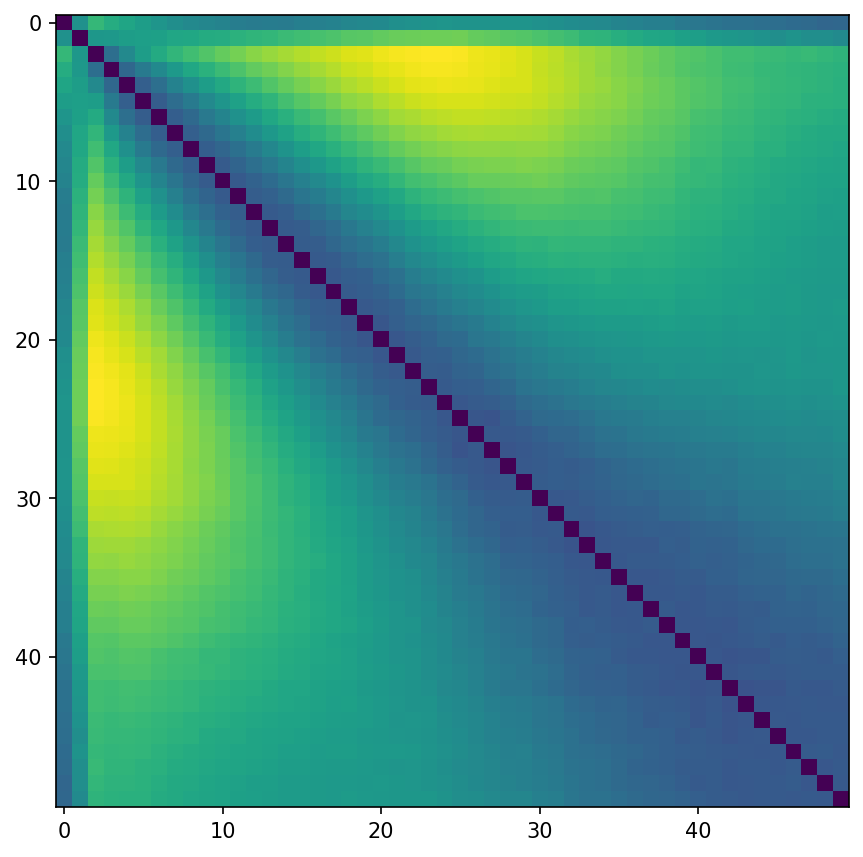

In [17]:
_, ax = plt.subplots(figsize=(7, 7), dpi=150)
ax.imshow(M_enc[:50, :50])
plt.show()

In [18]:
seq = 'Today is the first day of school'

x = torch.LongTensor(ds.en_tokenizer.encode(seq).ids).unsqueeze(0)
print('Word embedding:\n', model.enc_emb.word_emb(x))
print('Position embedding:\n', model.enc_emb.pos_emb.weight)
print('Total embedding:\n', model.enc_emb(x))

Word embedding:
 tensor([[[ 0.3974,  1.3338,  0.4456,  ...,  0.0466, -1.5812, -0.0478],
         [ 0.9164, -2.2703,  0.4485,  ...,  0.4641, -1.4530, -0.6834],
         [ 0.8230, -0.9493, -0.0536,  ..., -0.8756, -0.4870, -0.1131],
         ...,
         [-0.6808, -0.6446, -0.6344,  ...,  0.1201,  0.8015, -0.9617],
         [ 1.3064,  0.7145, -0.3726,  ...,  0.1914,  1.4262, -0.1932],
         [ 0.5787,  0.5943,  0.1462,  ...,  0.0927, -1.2652, -0.1206]]],
       grad_fn=<EmbeddingBackward>)
Position embedding:
 Parameter containing:
tensor([[ 0.7014, -1.9116, -2.0101,  ..., -0.1933, -0.7427,  0.0642],
        [ 0.1797, -1.7709, -3.5186,  ...,  0.0487, -3.8656, -4.5501],
        [-3.9209, -1.2570, -3.5439,  ..., -0.0209, -3.3564, -0.0838],
        ...,
        [ 1.7904, -1.0147,  2.0733,  ...,  0.6342,  1.3315,  0.1671],
        [-0.1189, -0.1489,  0.8026,  ...,  0.9172, -0.7820,  1.6459],
        [-0.9398, -0.9894,  0.1774,  ...,  0.4703,  0.5049, -1.2849]],
       requires_grad=True)
T